In [1]:
# import sys
# import jax
# from numpyro import optim
# jax.config.update('jax_enable_x64', True)  # Use float64
# jax.config.update("jax_default_matmul_precision", "highest")
# # sys.path.append('wishart-process')
# import inference
# import models
# import visualizations
# import evaluation
# import utils

import jax.numpy as jnp
# import numpyro
import itertools
from tqdm import tqdm
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt

# import data

In [2]:
#import data

import matplotlib.pyplot as plt
# SATED_DECONV = np.load('../Data/predictions_fullTrace_sated.npy', allow_pickle=True)
# ANG_STIM_DATA = loadmat('../Data/metadata_deconv/stimAngle_sated.mat', simplify_cells=True)
# SF_STIM_DATA  = loadmat('../Data/metadata_deconv/stimSpatFreq_sated.mat', simplify_cells=True)
# SATED_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
# SATED_SF    = SF_STIM_DATA['stimSpatFreq_arossAnimals']

# FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
# CONTROL_SATED         = [0,4,5,9,10,13]

HUNGRY_DECONV = np.load('../Data/predictions_fullTrace_hungry.npy', allow_pickle=True)
AngStim_data = '../Data/metadata_deconv/stimAngle_hungry.mat'
ANG_STIM_DATA = loadmat(AngStim_data, simplify_cells=True)
HUNGRY_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
SfStim_data = '../Data/metadata_deconv/stimSpatFreq_hungry.mat'
SF_STIM_DATA = loadmat(SfStim_data, simplify_cells=True)
HUNGRY_SF = SF_STIM_DATA['stimSpatFreq_arossAnimals']

FOOD_RESTRICTED_HUNGRY = [1,2,3,6,7,9,11,12]
CONTROL_HUNGRY = [0,4,5,8,10,13]

def resort_preprocessing(datum,angle_arr,sf_arr,animal):
    data = np.copy(datum[animal,:])
    neurons = data[0].shape[0]
    reshape_data = np.full((60,neurons,data[0].shape[1]), np.nan)
    for i in range(60):
        reshape_data[i,:,:] = data[i]

    reshape_data = reshape_data.reshape(60,neurons,12,120)
    reshape_data = np.transpose(reshape_data,(1,2,0,3))
    #Remove first two neurons
    reshape_data = reshape_data[2:,:,:,:]

    #Remove None trials
    max_trial = np.argmax(np.isnan(reshape_data[0,1,:,0]))
    reshape_data = reshape_data[:,:,:max_trial,:]

    # Remove beginning and last bit # HMMMM should I do this?
    # reshape_data[:,0,:,:32] = np.nan
    # reshape_data[:,-1,:,88:] = np.nan
    # print(np.any(np.isnan(reshape_data)))
    # print(reshape_data.shape)
    
    # Reorder angles
    angles = np.copy(angle_arr[animal])
    for itrials in range(angles.shape[1]):
        order = angles[:,itrials]-1
        reshape_data[:,:,itrials,:] = reshape_data[:,order,itrials,:]

    # Reorder SFs
    reshaped_data = []
    sfs = np.copy(sf_arr[animal])
    for experiment in range(1,6):
        mask = sfs == experiment
        reshaped_data.append(reshape_data[:,:,mask,:])

    max_trials = max([exp.shape[2] for exp in reshaped_data])
    # Pad the data for experiments with (10, 12, 80)fewer trials
    for i in range(len(reshaped_data)):
        if reshaped_data[i].shape[2] < max_trials:
            padding = max_trials - reshaped_data[i].shape[2]
            reshaped_data[i] = np.pad(reshaped_data[i], ((0, 0),(0, 0),(0, padding),(0, 0)), mode='constant', constant_values=np.nan)

    reshaped_data = np.stack(reshaped_data,axis=2)    

    return reshaped_data
x = resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,0)
print(np.sum(np.isnan(x)))




def remove_neurons(datum, angles,sfs, animal, count = False):
    neurons_to_keep = []
    data = resort_preprocessing(datum,angles,sfs,animal)
    number_neurons = data.shape[0]    
    for i in range(number_neurons):
        # print(np.nanmean(data[i, :, :, :, 40:80], axis = 3))
        stim_average = np.mean(data[i, :, :, :, 40:80], axis = 3) # OKAY TO NOT HAVE NANMEAN?
        best_sf = np.argmax(np.nanmean(stim_average, axis = (0,2))).astype('int')
        best_angle = np.argmax(np.nanmean(stim_average[:,best_sf,:], axis = 1)).astype('int')
        averaged_calcium = np.nanmean(stim_average[best_angle,best_sf,:])
        
        grey_data = data[i, :, :, :, 0:20]
        # grey_data = np.concatenate((data[i, :, :, :, 0:40], data[i, :, :, :, 80:]), axis = 3)
        grey_average = np.mean(grey_data, axis = 3)
        best_sf = np.argmax(np.nanmean(grey_average, axis = (0,2))).astype(int)
        best_angle = np.argmax(np.nanmean(grey_average[:,best_sf,:], axis = 1)).astype(int)
        average_grey = np.nanmean(grey_average[best_angle,best_sf,:])
        std_grey = np.nanstd(grey_average[best_angle,best_sf,:])
        
        if np.abs(averaged_calcium - average_grey) >= 1.69*std_grey:
            neurons_to_keep.append(i)
    
    # Keep only the neurons that meet the condition
    data_filtered = data[neurons_to_keep, :, :,:,:]
    if count:
        return data_filtered.shape[0]/data.shape[0]

    return data_filtered



450560


In [3]:
TEST_DATA = resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,0)[:,:,0,:,40:80]
# Animal = 0, SF = 0 and during response
TEST_RESPONSE = jnp.nanmean(TEST_DATA,axis = -1) # Shape N x C x K 
TEST_RESPONSE = jnp.transpose(TEST_RESPONSE, (2,1,0)) # Shape K X C X N
print(TEST_RESPONSE.shape)
N = TEST_RESPONSE.shape[2]
C = TEST_RESPONSE.shape[1]
K = TEST_RESPONSE.shape[0]
SEED = 1
PERIOD = C
X_CONDITIONS = jnp.linspace(0,C-1,C)

# keep only trials that have at least one finite value
good_trials = ~jnp.isnan(TEST_RESPONSE).all(axis=(1, 2))   # shape (K,)
TEST_RESPONSE = TEST_RESPONSE[good_trials]                 # (K′, C, N)
K = TEST_RESPONSE.shape[0]
print(f"{K} good trials remain")


# Z-score test response along the trial axis
# TEST_RESPONSE = (TEST_RESPONSE - jnp.nanmean(TEST_RESPONSE, axis=0)) / jnp.nanstd(TEST_RESPONSE, axis=0)


(11, 12, 128)
11 good trials remain


# Compare to Empirical

(12, 128)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


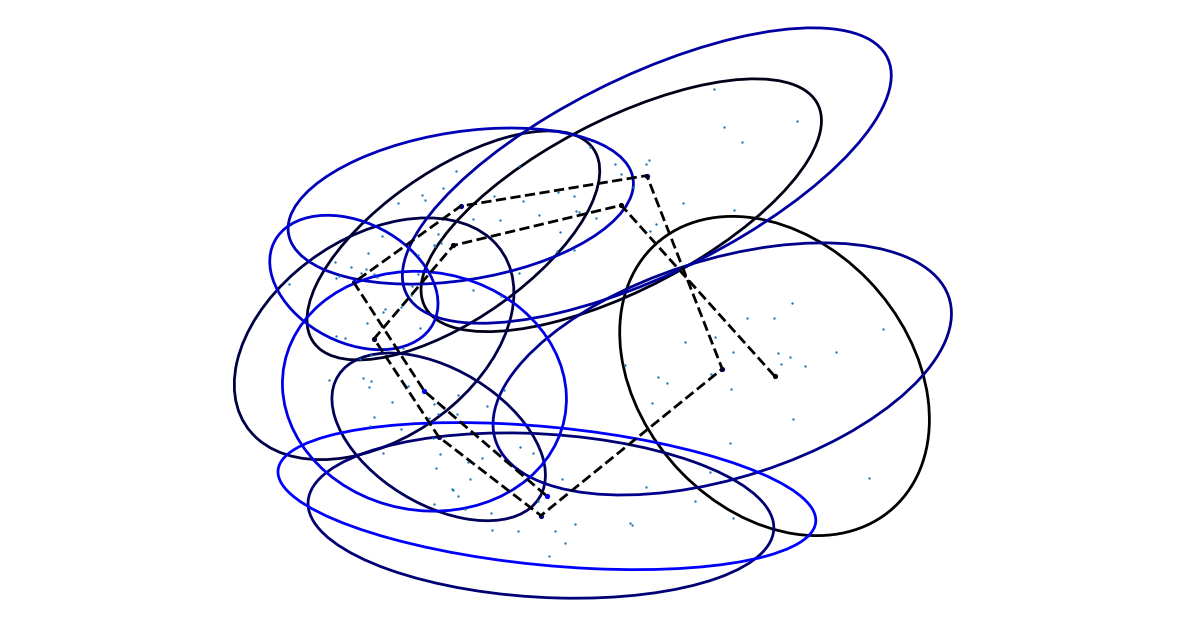

In [17]:
import pandas as pd
empirical_mu = jnp.nanmean(TEST_RESPONSE,axis=0)
print(empirical_mu.shape)
# empirical_cov =jnp.cov(TEST_RESPONSE,axis=0)
empirical_sigma = jnp.zeros((C, N, N))
for i in range(C):
    dat = TEST_RESPONSE[:,i,:] # Shape K x N
    df = pd.DataFrame(dat)
    covariances = df.cov().to_numpy()
    covariances += np.eye(N) * 1e-6
    empirical_sigma = empirical_sigma.at[i].set(covariances)
visualizations.visualize_pc(
    empirical_mu[:,None],empirical_sigma,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)


## SNR Overall Bar

(12, 5, 162) (12, 5, 162) (48, 5, 162) (48, 5, 162)
(12, 5, 106) (12, 5, 106) (48, 5, 106) (48, 5, 106)
(12, 5, 114) (12, 5, 114) (48, 5, 114) (48, 5, 114)
(12, 5, 136) (12, 5, 136) (48, 5, 136) (48, 5, 136)
(12, 5, 104) (12, 5, 104) (48, 5, 104) (48, 5, 104)
(12, 5, 109) (12, 5, 109) (48, 5, 109) (48, 5, 109)
(12, 5, 235) (12, 5, 235) (48, 5, 235) (48, 5, 235)
(12, 5, 129) (12, 5, 129) (48, 5, 129) (48, 5, 129)
(12, 5, 137) (12, 5, 137) (48, 5, 137) (48, 5, 137)
(12, 5, 112) (12, 5, 112) (48, 5, 112) (48, 5, 112)
(12, 5, 56) (12, 5, 56) (48, 5, 56) (48, 5, 56)
(12, 5, 94) (12, 5, 94) (48, 5, 94) (48, 5, 94)
(12, 5, 104) (12, 5, 104) (48, 5, 104) (48, 5, 104)
(12, 5, 134) (12, 5, 134) (48, 5, 134) (48, 5, 134)


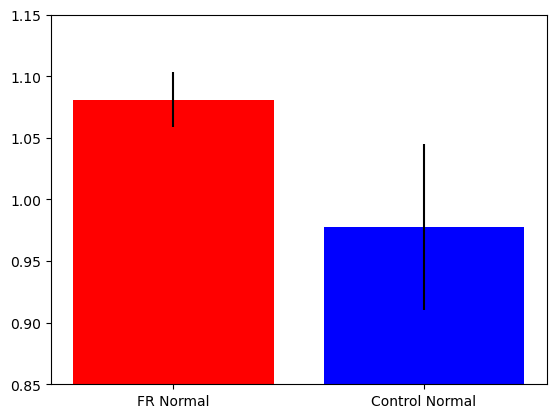

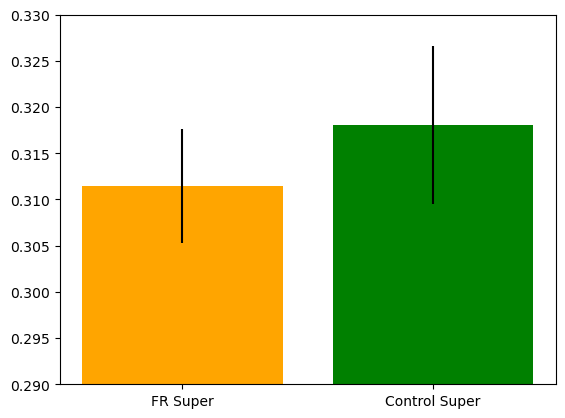

In [6]:
import numpy as np
from types import SimpleNamespace

rag_fr = np.load('../Data/overlaps_sated_fr_ragged_2.npz', allow_pickle=True)
overlaps_normal_dict_fr = rag_fr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr = rag_fr['eigs_normal'].item()  # dict[str->ndarray]

overlaps_super_dict_fr = rag_fr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr = rag_fr['eigs_super'].item()  # dict[str->ndarray]


rag_ctr = np.load('../Data/overlaps_sated_ctr_ragged_2.npz', allow_pickle=True)
overlaps_normal_dict_ctr = rag_ctr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr = rag_ctr['eigs_normal'].item()
overlaps_super_dict_ctr = rag_ctr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr = rag_ctr['eigs_super'].item()  # dict[str



FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

import matplotlib.pyplot as plt

average_fr_normal = []
average_fr_super = []
for animal in FOOD_RESTRICTED_SATED:
    normal_overlaps = overlaps_normal_dict_fr[animal]
    normal_eigs = eigs_normal_dict_fr[animal]
    super_overlaps = overlaps_super_dict_fr[animal]
    super_eigs = eigs_super_dict_fr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))

    average_fr_normal.append(np.nanmean(mean_snr))
    average_fr_super.append(np.nanmean(mean_snr_super))
    print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)

average_ctr_normal = []
average_ctr_super = []
for animal in CONTROL_SATED:
    normal_overlaps = overlaps_normal_dict_ctr[animal]
    normal_eigs = eigs_normal_dict_ctr[animal]
    super_overlaps = overlaps_super_dict_ctr[animal]
    super_eigs = eigs_super_dict_ctr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))

    average_ctr_normal.append(np.nanmean(mean_snr))
    average_ctr_super.append(np.nanmean(mean_snr_super))
    print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)
plt.bar([0,1], [np.mean(average_fr_normal), np.mean(average_ctr_normal)], yerr=[np.std(average_fr_normal)/np.sqrt(len(average_fr_normal)), np.std(average_ctr_normal)/np.sqrt(len(average_ctr_normal))], tick_label=['FR Normal', 'Control Normal'], color=['red', 'blue']  )
plt.ylim(0.85,1.15)
plt.show()
plt.bar([0,1], [np.mean(average_fr_super), np.mean(average_ctr_super)], yerr=[np.std(average_fr_super)/np.sqrt(len(average_fr_super)), np.std(average_ctr_super)/np.sqrt(len(average_ctr_super))], tick_label=['FR Super', 'Control Super'], color=['orange', 'green']  )
plt.ylim(0.29,0.33)
plt.show()


# Check

FR Normal: n=8, mean=1.081, SEM=0.02383
  Top variance contributor: idx=0, value=1.22
  Contribution to variance: 60.6%
  SEM if dropped: 0.01526  (change: +36.0%)
  ↳ Error likely dominated by a single value.
Control Normal: n=6, mean=0.9774, SEM=0.07394
  Top variance contributor: idx=0, value=1.302
  Contribution to variance: 64.2%
  SEM if dropped: 0.04336  (change: +41.4%)
  ↳ Error likely dominated by a single value.
FR Super: n=8, mean=0.3115, SEM=0.006585
  Top variance contributor: idx=4, value=0.3536
  Contribution to variance: 73.1%
  SEM if dropped: 0.003079  (change: +53.2%)
  ↳ Error likely dominated by a single value.
Control Super: n=6, mean=0.3181, SEM=0.009346
  Top variance contributor: idx=5, value=0.274
  Contribution to variance: 74.0%
  SEM if dropped: 0.003834  (change: +59.0%)
  ↳ Error likely dominated by a single value.


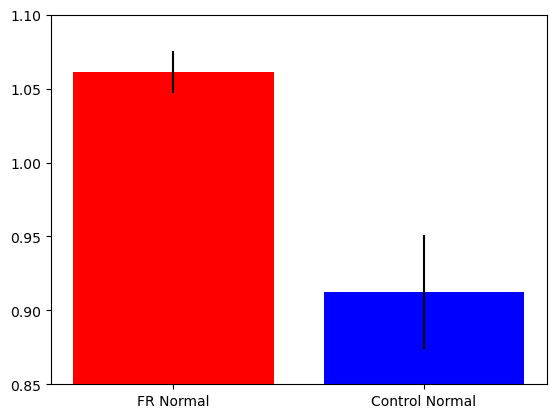

(0.29, 0.34)

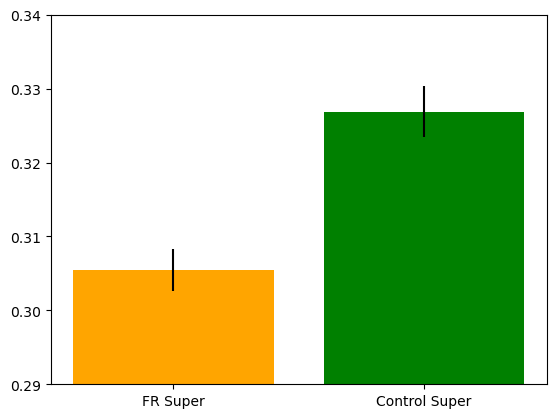

In [7]:
def sem_influence(x, name="group"):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        print(f"{name}: empty array"); 
        return

    mu = x.mean()
    sd = x.std(ddof=1) if n > 1 else 0.0
    sem = sd / np.sqrt(n) if n > 1 else 0.0

    # Variance contribution of each point
    r2 = (x - mu)**2
    total_ss = r2.sum()
    contrib = r2 / total_ss if total_ss > 0 else np.zeros_like(x)

    # Leave-one-out SEM (undefined for n<3)
    if n >= 3:
        loo_sem = np.array([
            np.std(np.delete(x, i), ddof=1) / np.sqrt(n - 1) for i in range(n)
        ])
        # How much SEM drops if we remove point i (positive = this point inflates SEM)
        sem_drop = sem - loo_sem
    else:
        loo_sem = np.full(n, np.nan)
        sem_drop = np.full(n, np.nan)

    # Report top influencer
    i_top = int(np.nanargmax(contrib))
    dominance = contrib[i_top]
    drop_pct = (sem_drop[i_top] / sem) * 100 if sem > 0 and np.isfinite(sem_drop[i_top]) else np.nan

    print(f"{name}: n={n}, mean={mu:.4g}, SEM={sem:.4g}")
    print(f"  Top variance contributor: idx={i_top}, value={x[i_top]:.4g}")
    print(f"  Contribution to variance: {dominance*100:.1f}%")
    if np.isfinite(drop_pct):
        print(f"  SEM if dropped: {loo_sem[i_top]:.4g}  (change: {drop_pct:+.1f}%)")

    # Optional: simple dominance flags
    dominated = (dominance > 0.5) or (np.isfinite(drop_pct) and drop_pct > 30)
    if dominated:
        print("  ↳ Error likely dominated by a single value.")
    else:
        print("  ↳ No single value appears to dominate.")
    
    #return index of top influencer
    return i_top

# Use on your data:
itop_fr_n = sem_influence(average_fr_normal,   "FR Normal")
itop_ctr_n = sem_influence(average_ctr_normal,  "Control Normal")
itop_fr_s = sem_influence(average_fr_super,    "FR Super")
itop_ctr_s = sem_influence(average_ctr_super,   "Control Super")


dropped_fr_normal = [x for i,x in enumerate(average_fr_normal) if i!=itop_fr_n]
dropped_ctr_normal = [x for i,x in enumerate(average_ctr_normal) if i!=itop_ctr_n]
dropped_fr_super = [x for i,x in enumerate(average_fr_super) if i!=itop_fr_s]
dropped_ctr_super = [x for i,x in enumerate(average_ctr_super) if i!=itop_ctr_s]
plt.bar([0,1], [np.mean(dropped_fr_normal), np.mean(dropped_ctr_normal)], yerr=[np.std(dropped_fr_normal)/np.sqrt(len(dropped_fr_normal)), np.std(dropped_ctr_normal)/np.sqrt(len(dropped_ctr_normal))], tick_label=['FR Normal', 'Control Normal'], color=['red', 'blue']  )
plt.ylim(0.85,1.10)
plt.show()
plt.bar([0,1], [np.mean(dropped_fr_super), np.mean(dropped_ctr_super)], yerr=[np.std(dropped_fr_super)/np.sqrt(len(dropped_fr_super)), np.std(dropped_ctr_super)/np.sqrt(len(dropped_ctr_super))], tick_label=['FR Super', 'Control Super'], color=['orange', 'green']  )
plt.ylim(0.29,0.34)

## Early vs Late SNR barchart

(12, 5, 162) (12, 5, 162) (48, 5, 162) (48, 5, 162)
(12, 5, 106) (12, 5, 106) (48, 5, 106) (48, 5, 106)
(12, 5, 114) (12, 5, 114) (48, 5, 114) (48, 5, 114)
(12, 5, 136) (12, 5, 136) (48, 5, 136) (48, 5, 136)
(12, 5, 104) (12, 5, 104) (48, 5, 104) (48, 5, 104)
(12, 5, 109) (12, 5, 109) (48, 5, 109) (48, 5, 109)
(12, 5, 235) (12, 5, 235) (48, 5, 235) (48, 5, 235)
(12, 5, 129) (12, 5, 129) (48, 5, 129) (48, 5, 129)
(12, 5, 137) (12, 5, 137) (48, 5, 137) (48, 5, 137)
(12, 5, 112) (12, 5, 112) (48, 5, 112) (48, 5, 112)
(12, 5, 56) (12, 5, 56) (48, 5, 56) (48, 5, 56)
(12, 5, 94) (12, 5, 94) (48, 5, 94) (48, 5, 94)
(12, 5, 104) (12, 5, 104) (48, 5, 104) (48, 5, 104)
(12, 5, 134) (12, 5, 134) (48, 5, 134) (48, 5, 134)


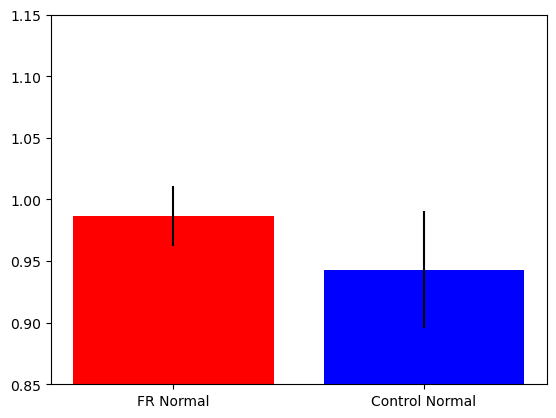

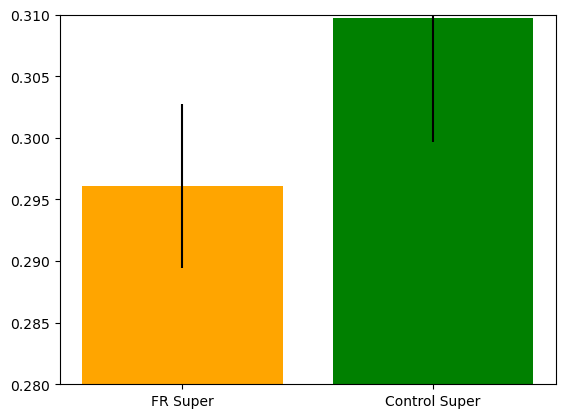

In [14]:
import numpy as np
from types import SimpleNamespace

rag_fr = np.load('../Data/overlaps_sated_fr_ragged_3_late.npz', allow_pickle=True)
overlaps_normal_dict_fr = rag_fr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_fr = rag_fr['eigs_normal'].item()  # dict[str->ndarray]

overlaps_super_dict_fr = rag_fr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_fr = rag_fr['eigs_super'].item()  # dict[str->ndarray]


rag_ctr = np.load('../Data/overlaps_sated_ctr_ragged_3_late.npz', allow_pickle=True)
overlaps_normal_dict_ctr = rag_ctr['overlaps_normal'].item()  # dict[str->ndarray]
eigs_normal_dict_ctr = rag_ctr['eigs_normal'].item()
overlaps_super_dict_ctr = rag_ctr['overlaps_super'].item()  # dict[str->ndarray]
eigs_super_dict_ctr = rag_ctr['eigs_super'].item()  # dict[str



FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

import matplotlib.pyplot as plt

average_fr_normal = []
average_fr_super = []
for animal in FOOD_RESTRICTED_SATED:
    normal_overlaps = overlaps_normal_dict_fr[animal]
    normal_eigs = eigs_normal_dict_fr[animal]
    super_overlaps = overlaps_super_dict_fr[animal]
    super_eigs = eigs_super_dict_fr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))

    average_fr_normal.append(np.nanmean(mean_snr))
    average_fr_super.append(np.nanmean(mean_snr_super))
    print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)

average_ctr_normal = []
average_ctr_super = []
for animal in CONTROL_SATED:
    normal_overlaps = overlaps_normal_dict_ctr[animal]
    normal_eigs = eigs_normal_dict_ctr[animal]
    super_overlaps = overlaps_super_dict_ctr[animal]
    super_eigs = eigs_super_dict_ctr[animal]
    snr = normal_overlaps/normal_eigs
    snr_super = super_overlaps/super_eigs
    mean_snr = np.nanmean(snr, axis=(0,1))
    mean_snr_super = np.nanmean(snr_super, axis=(0,1))

    average_ctr_normal.append(np.nanmean(mean_snr))
    average_ctr_super.append(np.nanmean(mean_snr_super))
    print(normal_overlaps.shape, normal_eigs.shape, super_overlaps.shape, super_eigs.shape)
plt.bar([0,1], [np.mean(average_fr_normal), np.mean(average_ctr_normal)], yerr=[np.std(average_fr_normal)/np.sqrt(len(average_fr_normal)), np.std(average_ctr_normal)/np.sqrt(len(average_ctr_normal))], tick_label=['FR Normal', 'Control Normal'], color=['red', 'blue']  )
plt.ylim(0.85,1.15)
plt.show()
plt.bar([0,1], [np.mean(average_fr_super), np.mean(average_ctr_super)], yerr=[np.std(average_fr_super)/np.sqrt(len(average_fr_super)), np.std(average_ctr_super)/np.sqrt(len(average_ctr_super))], tick_label=['FR Super', 'Control Super'], color=['orange', 'green']  )
plt.ylim(0.28,0.31)
plt.show()


FR Normal: n=8, mean=0.9867, SEM=0.02597
  Top variance contributor: idx=0, value=1.12
  Contribution to variance: 47.2%
  SEM if dropped: 0.02035  (change: +21.7%)
  ↳ No single value appears to dominate.
Control Normal: n=6, mean=0.9431, SEM=0.05195
  Top variance contributor: idx=0, value=1.147
  Contribution to variance: 51.2%
  SEM if dropped: 0.03949  (change: +24.0%)
  ↳ Error likely dominated by a single value.
FR Super: n=8, mean=0.2961, SEM=0.007136
  Top variance contributor: idx=4, value=0.342
  Contribution to variance: 73.9%
  SEM if dropped: 0.003253  (change: +54.4%)
  ↳ Error likely dominated by a single value.
Control Super: n=6, mean=0.3097, SEM=0.01105
  Top variance contributor: idx=5, value=0.257
  Contribution to variance: 75.9%
  SEM if dropped: 0.004044  (change: +63.4%)
  ↳ Error likely dominated by a single value.


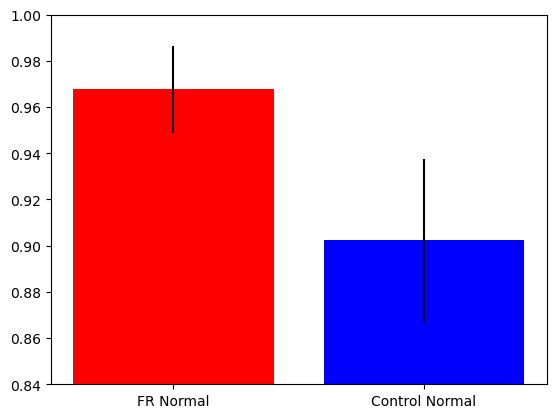

(0.28, 0.35)

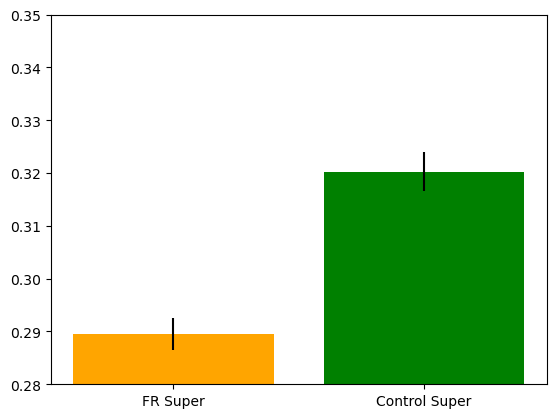

In [15]:
itop_fr_n = sem_influence(average_fr_normal,   "FR Normal")
itop_ctr_n = sem_influence(average_ctr_normal,  "Control Normal")
itop_fr_s = sem_influence(average_fr_super,    "FR Super")
itop_ctr_s = sem_influence(average_ctr_super,   "Control Super")


dropped_fr_normal = [x for i,x in enumerate(average_fr_normal) if i!=itop_fr_n]
dropped_ctr_normal = [x for i,x in enumerate(average_ctr_normal) if i!=itop_ctr_n]
dropped_fr_super = [x for i,x in enumerate(average_fr_super) if i!=itop_fr_s]
dropped_ctr_super = [x for i,x in enumerate(average_ctr_super) if i!=itop_ctr_s]
plt.bar([0,1], [np.mean(dropped_fr_normal), np.mean(dropped_ctr_normal)], yerr=[np.std(dropped_fr_normal)/np.sqrt(len(dropped_fr_normal)), np.std(dropped_ctr_normal)/np.sqrt(len(dropped_ctr_normal))], tick_label=['FR Normal', 'Control Normal'], color=['red', 'blue']  )
plt.ylim(0.84,1)
plt.show()
plt.bar([0,1], [np.mean(dropped_fr_super), np.mean(dropped_ctr_super)], yerr=[np.std(dropped_fr_super)/np.sqrt(len(dropped_fr_super)), np.std(dropped_ctr_super)/np.sqrt(len(dropped_ctr_super))], tick_label=['FR Super', 'Control Super'], color=['orange', 'green']  )
plt.ylim(0.28,0.35)

# New Analysis

In [4]:
import pickle
from pathlib import Path
from scipy import stats 
def load_overlap_eigs(save_dir, group_prefix, animal, sf):
    """
    group_prefix: 'FR' or 'CTR' (or whatever you used as fname_prefix)
    sf: int or None
    """
    sf_tag = "best_sf" if sf is None else f"sf{int(sf)}"
    p = Path(save_dir) / f"{group_prefix}_{animal}_{sf_tag}_overlaps_eigs.pkl"
    with open(p, "rb") as f:
        return pickle.load(f)


folder_name = "saved_overlap_eigs_normal_hungry_23_10_test_2"
# folder_name = "saved_overlap_eigs_normal_2509_smaller"
# folder_name = "saved_overlap_eigs_normal_2509_smaller_sf_sum"
# folder_name = "saved_overlap_eigs_normal_2509_smaller_sf_sum_remove"



Text(0, 0.5, 'Performance ')

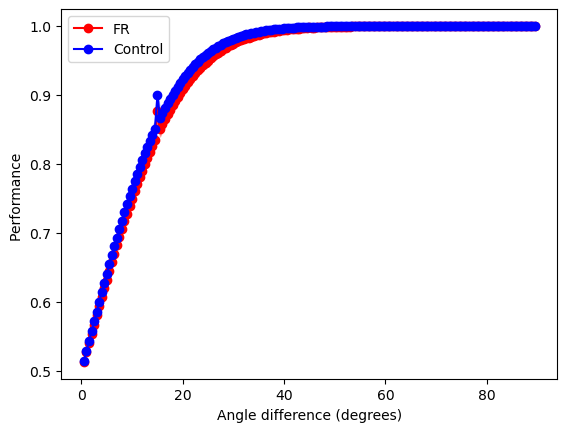

In [8]:
M0 = load_overlap_eigs(folder_name, "FR", f"{1}", sf=None)['snr_per_condition'].shape[0]
deg_step = 720.0 / (M0 + 2)  # since M = 2*(n_fine-1)
conditions_saved = np.arange(deg_step, 90.0, deg_step)
n_bins = conditions_saved.size  # number of angles strictly < 90°
sum_snr_value_fr = np.full((8,n_bins),np.nan)
for idx, animal_number in enumerate(FOOD_RESTRICTED_HUNGRY):
    data = load_overlap_eigs(folder_name, "FR", f"{animal_number}", sf=None)['snr_per_condition']
    pos, neg = np.split(data, 2, axis=0)  # requires even M; raises if not equal halves
    snr_pm = 0.5 * (pos + neg)          # (L, C, R) with L = pos.shape[0]
    snr_close = snr_pm[:n_bins,:,:]
    sum_snr_value_fr[idx,:] = np.mean(snr_close, axis=(1,2))



sum_snr_value_ctr = np.full((6,len(conditions_saved)),np.nan)
for idx,animal_number in enumerate(CONTROL_HUNGRY):
    if animal_number == 5:
        continue
    data = load_overlap_eigs(folder_name, "CTR", f"{animal_number}", sf=None)['snr_per_condition']
    pos, neg = np.split(data, 2, axis=0)
    snr_pm = 0.5 * (pos + neg)
    sum_snr_value_ctr[idx, :] = np.mean(snr_pm[:n_bins, :, :], axis=(1, 2))

snr_fr = np.nanmean(sum_snr_value_fr, axis=(0))
snr_fr_sem = np.nanstd(sum_snr_value_fr, axis=(0))/np.sqrt(sum_snr_value_fr.shape[0])
snr_ctr = np.nanmean(sum_snr_value_ctr, axis=(0))
snr_ctr_sem = np.nanstd(sum_snr_value_ctr, axis=(0))/np.sqrt(sum_snr_value_ctr.shape[0])
performance_fr = stats.norm.cdf(np.sqrt(snr_fr)/2)
performance_ctr = stats.norm.cdf(np.sqrt(snr_ctr)/2)
performance_fr_sem = (np.exp(-snr_fr/8)/(4*np.sqrt(2*np.pi*snr_fr)))*snr_fr_sem
performance_ctr_sem = (np.exp(-snr_ctr/8)/(4*np.sqrt(2*np.pi*snr_ctr)))*snr_ctr_sem
# print(conditions_saved.shape, sum_snr_value_fr.shape, sum_snr_value_ctr.shape)
# plt.scatter(np.array(conditions_saved), snr_fr, color = 'red')
# plt.fill_between(np.array(conditions_saved), snr_fr - snr_fr_sem, snr_fr + snr_fr_sem, color='red', alpha=0.3)
# plt.scatter(np.array(conditions_saved), snr_ctr, color = 'blue')
# plt.fill_between(np.array(conditions_saved), snr_ctr - snr_ctr_sem, snr_ctr + snr_ctr_sem, color='blue', alpha=0.3)
plt.xlabel('Angle difference (degrees)')
plt.ylabel('SNR (80 random neurons)')


# print(conditions_saved.shape, sum_snr_value_fr.shape, sum_snr_value_ctr.shape)
# plt.figure()
plt.plot(np.array(conditions_saved), performance_fr, color='red', marker='o', linestyle='-', label='FR')
plt.fill_between(np.array(conditions_saved), performance_fr - performance_fr_sem, performance_fr + performance_fr_sem, color='red', alpha=0.3)
plt.plot(np.array(conditions_saved), performance_ctr, color='blue', marker='o', linestyle='-', label='Control')
plt.fill_between(np.array(conditions_saved), performance_ctr - performance_ctr_sem, performance_ctr + performance_ctr_sem, color='blue', alpha=0.3)
plt.legend()
plt.xlabel('Angle difference (degrees)')
plt.ylabel('Performance ')
# plt.xlim(0,20)
# plt.ylim(0,)


(0.56, 0.75)

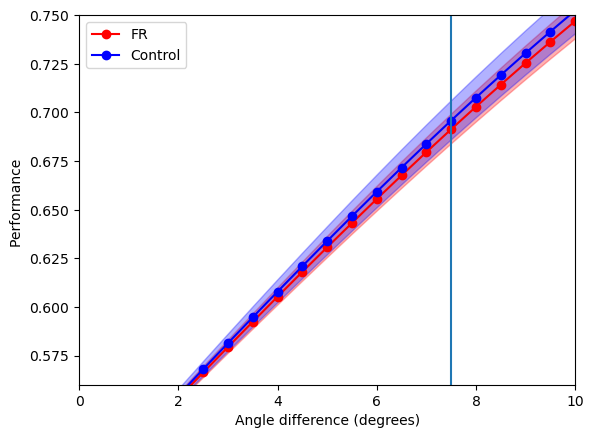

In [25]:
M0 = load_overlap_eigs(folder_name, "FR", f"{1}", sf=None)['snr_per_condition'].shape[0]
deg_step = 720.0 / (M0 + 2)  # since M = 2*(n_fine-1)
conditions_saved = np.arange(deg_step, 90.0, deg_step)
n_bins = conditions_saved.size  # number of angles strictly < 90°
sum_snr_value_fr = np.full((8,n_bins),np.nan)
for idx, animal_number in enumerate(FOOD_RESTRICTED_HUNGRY):
    data = load_overlap_eigs(folder_name, "FR", f"{animal_number}", sf=None)
    overlaps = data['overlaps_per_condition']
    eigs = data['eigs_per_condition']
    snr = np.nansum(overlaps/eigs, axis = -1)

    pos, neg = np.split(snr, 2, axis=0)  # requires even M; raises if not equal halves
    snr_pm = 0.5 * (pos + neg)            # (L, C, R) with L = pos.shape[0]
    snr_close = snr_pm[:n_bins,:,:]
    sum_snr_value_fr[idx,:] = np.mean(snr_close, axis=(1,2))



sum_snr_value_ctr = np.full((6,len(conditions_saved)),np.nan)
for idx,animal_number in enumerate(CONTROL_HUNGRY):
    data = load_overlap_eigs(folder_name, "CTR", f"{animal_number}", sf=None)
    overlaps = data['overlaps_per_condition']
    eigs = data['eigs_per_condition']
    snr = np.nansum(overlaps/eigs, axis = -1)
    pos, neg = np.split(snr, 2, axis=0)
    snr_pm = 0.5 * (pos + neg)
    sum_snr_value_ctr[idx, :] = np.mean(snr_pm[:n_bins, :, :], axis=(1, 2))
snr_fr = np.nanmean(sum_snr_value_fr, axis=(0))
snr_fr_sem = np.nanstd(sum_snr_value_fr, axis=(0))/np.sqrt(sum_snr_value_fr.shape[0])
snr_ctr = np.nanmean(sum_snr_value_ctr, axis=(0))
snr_ctr_sem = np.nanstd(sum_snr_value_ctr, axis=(0))/np.sqrt(sum_snr_value_ctr.shape[0])
performance_fr = stats.norm.cdf(np.sqrt(snr_fr)/2)
performance_ctr = stats.norm.cdf(np.sqrt(snr_ctr)/2)
performance_fr_sem = (np.exp(-snr_fr/8)/(4*np.sqrt(2*np.pi*snr_fr)))*snr_fr_sem
performance_ctr_sem = (np.exp(-snr_ctr/8)/(4*np.sqrt(2*np.pi*snr_ctr)))*snr_ctr_sem
# # print(conditions_saved.shape, sum_snr_value_fr.shape, sum_snr_value_ctr.shape)
# plt.scatter(np.array(conditions_saved), snr_fr, color = 'red')
# plt.fill_between(np.array(conditions_saved), snr_fr - snr_fr_sem, snr_fr + snr_fr_sem, color='red', alpha=0.3)
# plt.scatter(np.array(conditions_saved), snr_ctr, color = 'blue')
# plt.fill_between(np.array(conditions_saved), snr_ctr - snr_ctr_sem, snr_ctr + snr_ctr_sem, color='blue', alpha=0.3)
# plt.xlabel('Angle difference (degrees)')
# plt.ylabel('SNR (80 random neurons)')


# print(conditions_saved.shape, sum_snr_value_fr.shape, sum_snr_value_ctr.shape)
# plt.figure()
plt.plot(np.array(conditions_saved), performance_fr, color='red', marker='o', linestyle='-', label='FR')
plt.fill_between(np.array(conditions_saved), performance_fr - performance_fr_sem, performance_fr + performance_fr_sem, color='red', alpha=0.3)
plt.plot(np.array(conditions_saved), performance_ctr, color='blue', marker='o', linestyle='-', label='Control')
plt.fill_between(np.array(conditions_saved), performance_ctr - performance_ctr_sem, performance_ctr + performance_ctr_sem, color='blue', alpha=0.3)
plt.legend()
plt.axvline(7.5)
plt.xlabel('Angle difference (degrees)')
plt.ylabel('Performance ')
plt.xlim(0,10)
plt.ylim(0.56,.75)

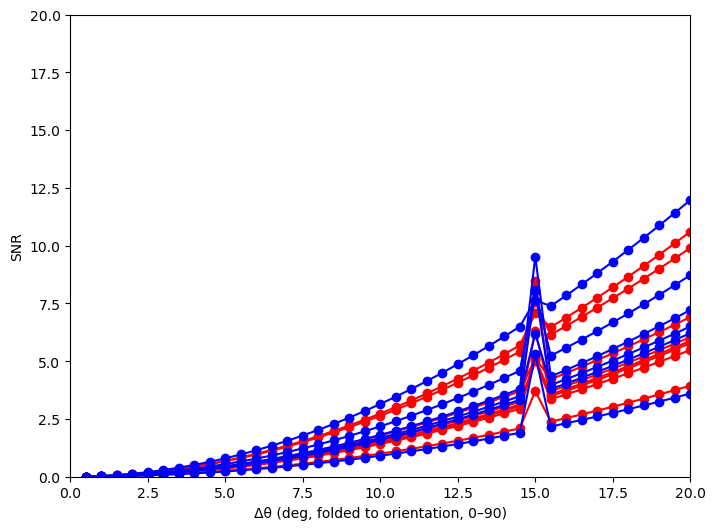

In [18]:
plt.figure(figsize=(8,6))

for animal in FOOD_RESTRICTED_HUNGRY:

    data = load_overlap_eigs(folder_name, "FR", f"{animal}", sf=None)
    overlaps = data['overlaps_per_condition']
    eigs = data['eigs_per_condition']
    snr = np.nansum(overlaps/eigs, axis = -1)
    # snr = data['snr_per_condition']
    pos, neg = np.split(snr, 2, axis=0)  # requires even M; raises if not equal halves
    snr_pm = 0.5 * (pos + neg)            # (L, C, R) with L = pos.shape[0]
    snr_close = snr_pm[:n_bins,:2,:]
    sum_snr_value_fr[idx,:] = np.mean(snr_close, axis=(1,2))
    plt.plot(conditions_saved, np.mean(snr_close, axis=(1,2)), marker='o', label=f'Animal {animal}', color  = 'red')
for animal in CONTROL_HUNGRY:
    # if animal in [9,10,13]:
        # continue
    data = load_overlap_eigs(folder_name, "CTR", f"{animal}", sf=None)
    overlaps = data['overlaps_per_condition']
    eigs = data['eigs_per_condition']
    snr = np.nansum(overlaps/eigs, axis = -1)
    # snr = data['snr_per_condition']
    pos, neg = np.split(snr, 2, axis=0)  # requires even M; raises if not equal halves
    snr_pm = 0.5 * (pos + neg)            # (L, C, R) with L = pos.shape[0]
    snr_close = snr_pm[:n_bins,:2,:]
    sum_snr_value_fr[idx,:] = np.mean(snr_close, axis=(1,2))
    plt.plot(conditions_saved, np.mean(snr_close, axis=(1,2)), marker='o', label=f'Animal {animal}', color  = 'blue')
    # plt.text(conditions_saved[-1], np.mean(snr_close, axis=(1,2))[-1], f'{animal}')
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlabel('Δθ (deg, folded to orientation, 0–90)')
plt.ylabel('SNR')

plt.show()


# Trying to infer

In [47]:
load_overlap_eigs(folder_name, "FR", f"{1}", sf=None)['snr_per_condition'].shape

(1438, 12, 100)

In [ ]:
M0 = load_overlap_eigs(folder_name, "FR", f"{1}", sf=None)['snr_per_condition'].shape[0]

deg_step = 720.0 / (M0 + 2)  # since M = 2*(n_fine-1)
conditions_saved = np.arange(deg_step, 90.0, deg_step)
n_bins = conditions_saved.size  # number of angles strictly < 90°
sum_snr_value_fr = np.full((8,n_bins),np.nan)
sum_snr_value_ctr = np.full((6,n_bins),np.nan)
beta = 1
epsilon = 100000
for i, animal in enumerate(FOOD_RESTRICTED_HUNGRY):
    data = load_overlap_eigs(folder_name, "FR", f"{animal}", sf=None)
    overlaps = data['overlaps_per_condition']
    eigs = data['eigs_per_condition']
    snr_per_mode = overlaps/eigs


    # snr_lda = np.nansum(overlaps/eigs, axis = -1)
    # numerator = snr_lda**2 + (1/beta)*np.nansum(overlaps/(eigs + epsilon), axis = -1)
    # denominator = snr_lda + (1/beta)*np.nansum(eigs/(eigs + epsilon)**2, axis = -1)
    # snr = numerator/denominator
    
    
    
    pos, neg = np.split(snr, 2, axis=0)  # requires even M; raises if not equal halves
    snr_pm = 0.5 * (pos + neg)            # (L, C, R) with L = pos.shape[0]
    snr_close = snr_pm[:n_bins,:2,:]
    sum_snr_value_fr[i,:] = np.nanmean(snr_close, axis=(1,2))



for i, animal in enumerate(CONTROL_HUNGRY):
    if animal in [5]:
        continue
    data = load_overlap_eigs(folder_name, "CTR", f"{animal}", sf=None)
    overlaps = data['overlaps_per_condition']
    eigs = data['eigs_per_condition']
    snr_lda = np.nansum(overlaps/eigs, axis = -1)

    # numerator = snr_lda**2 + (1/beta)*np.nansum(overlaps/(eigs + epsilon), axis = -1)
    # denominator = snr_lda + (1/beta)*np.nansum(eigs/(eigs + epsilon)**2, axis = -1)
    # snr = numerator/denominator



    pos, neg = np.split(snr, 2, axis=0)  # requires even M; raises if not equal halves
    snr_pm = 0.5 * (pos + neg)            # (L, C, R) with L = pos.shape[0]
    snr_close = snr_pm[:n_bins,:2,:]
    sum_snr_value_ctr[i,:] = np.nanmean(snr_close, axis=(1,2))
    



In [32]:
import numpy as np

# ---------- helpers ----------

def _angle_bins_from_M(M):
    """Recreate your angle binning from M."""
    deg_step = 720.0 / (M + 2)   # since M = 2*(n_fine-1)
    conditions_saved = np.arange(deg_step, 90.0, deg_step)
    n_bins = conditions_saved.size
    return conditions_saved, n_bins

def _compute_means_for_params(overlaps, eigs, betas, epsilons, n_bins):
    """
    Vectorized core: computes mean SNR across the first 2 conditions & all repeats,
    then averages 'pos/neg' halves and keeps only the first n_bins angles.

    overlaps, eigs: arrays with same shape (M, C, R, D) where D is the last axis you sum over
    betas:     1D array-like of betas (length B)
    epsilons:  1D array-like of epsilons (length E)

    Returns: means of shape (n_bins, E, B)
    """
    overlaps = np.asarray(overlaps)
    eigs     = np.asarray(eigs)
    betas    = np.asarray(betas, dtype=np.float64)
    epsilons = np.asarray(epsilons, dtype=np.float64)

    if overlaps.shape != eigs.shape:
        raise ValueError("overlaps and eigs must have identical shapes")

    # (M, C, R, D)
    M, C, R, D = overlaps.shape
    if (M % 2) != 0:
        raise ValueError("M must be even to split into pos/neg halves")

    # Precompute the epsilon-independent term once:
    # snr_lda = sum(overlaps/eigs, axis=-1) -> shape (M, C, R)
    snr_lda = np.nansum(overlaps / eigs, axis=-1)

    # Add parameter axes for efficient broadcasting:
    # shape them as (..., D, E) to sum over D and keep E
    overlaps_e = overlaps[..., None]                      # (M, C, R, D, 1)
    eigs_e     = eigs[..., None]                          # (M, C, R, D, 1)
    eps        = epsilons[None, None, None, None, :]      # (1, 1, 1, 1, E)

    inv_epe    = 1.0 / (eigs_e + eps)                     # (M, C, R, D, E)
    s1         = np.nansum(overlaps_e * inv_epe, axis=-2) # (M, C, R, E)
    s2         = np.nansum(eigs_e * inv_epe, axis=-2)  # (M, C, R, E)

    # Bring in betas via 1/beta broadcasting
    beta_inv = (1.0 / betas)[None, None, None, None, :]   # (1, 1, 1, 1, B)
    s1_b     = s1[..., :, None]                           # (M, C, R, E, B)
    s2_b     = s2[..., :, None]                           # (M, C, R, E, B)
    lda_b    = snr_lda[..., None, None]                   # (M, C, R, 1, B)  (B will broadcast)

    # snr = (lda^2 + (1/beta)*s1) / (lda + (1/beta)*s2)
    numerator   = lda_b**2 + beta_inv * s1_b              # (M, C, R, E, B)
    denominator = lda_b    + beta_inv * s2_b              # (M, C, R, E, B)
    snr         = s1_b # numerator / denominator                 # (M, C, R, E, B)

    # Average pos/neg halves along M, then take the first n_bins
    L = M // 2
    snr_pm    = 0.5 * (snr[:L] + snr[L:])                # (L, C, R, E, B)
    snr_close = snr_pm[:n_bins, :2, ...]                 # (n_bins, 2, R, E, B)

    # Mean across the first 2 conditions and across repeats
    # -> (n_bins, E, B)
    return np.nanmean(snr_close, axis=(1, 2))


def _preload_group(folder_name, group_label, animals, skip=None, cast_to=np.float32):
    """
    Load once and keep arrays in memory so you can sweep parameters fast.
    Returns list of dicts: [{"animal": id, "overlaps": ..., "eigs": ...}, ...]
    """
    data = []
    skip = set(skip or [])
    for a in animals:
        if a in skip:
            continue
        d = load_overlap_eigs(folder_name, group_label, f"{a}", sf=None)
        overlaps = d["overlaps_per_condition"]
        eigs     = d["eigs_per_condition"]
        if cast_to is not None:
            overlaps = overlaps.astype(cast_to, copy=False)
            eigs     = eigs.astype(cast_to, copy=False)
        data.append({"animal": a, "overlaps": overlaps, "eigs": eigs})
    return data


def sweep_beta_epsilon(folder_name, betas, epsilons,
                       fr_animals, ctr_animals, ctr_skip=(5,),
                       dtype=np.float32, chunk_eps=None):
    """
    High-level driver.
    - Loads FR/CTR once.
    - Computes angle bins from the first loaded dataset.
    - Evaluates all betas x epsilons (vectorized). If memory is tight, set chunk_eps (int)
      to process epsilons in blocks.

    Returns:
      conditions_saved,
      fr_means:  list over FR animals of arrays (n_bins, E, B)
      ctr_means: list over CTR animals of arrays (n_bins, E, B)
    """
    fr_data  = _preload_group(folder_name, "FR",  fr_animals, skip=None, cast_to=dtype)
    ctr_data = _preload_group(folder_name, "CTR", ctr_animals, skip=ctr_skip, cast_to=dtype)

    # Derive angle bins from the first loaded dataset (FR preferred, else CTR)
    src = fr_data[0] if len(fr_data) else ctr_data[0]
    M = src["overlaps"].shape[0]
    conditions_saved, n_bins = _angle_bins_from_M(M)

    # Optional epsilon chunking to cap memory usage
    betas = np.asarray(betas)
    epsilons = np.asarray(epsilons)
    if chunk_eps is None or chunk_eps >= len(epsilons):
        # Single pass over all eps
        fr_means = [
            _compute_means_for_params(d["overlaps"], d["eigs"], betas, epsilons, n_bins)
            for d in fr_data
        ]
        ctr_means = [
            _compute_means_for_params(d["overlaps"], d["eigs"], betas, epsilons, n_bins)
            for d in ctr_data
        ]
    else:
        # Blocked over epsilons to reduce peak memory
        def _blocked(d):
            blocks = []
            for i in range(0, len(epsilons), chunk_eps):
                block = _compute_means_for_params(
                    d["overlaps"], d["eigs"], betas, epsilons[i:i+chunk_eps], n_bins
                )  # (n_bins, e_blk, B)
                blocks.append(block)
            return np.concatenate(blocks, axis=1)  # concat along E
        fr_means  = [_blocked(d) for d in fr_data]
        ctr_means = [_blocked(d) for d in ctr_data]

    return conditions_saved, fr_means, ctr_means


# ---------- example usage (drop in replacement pattern) ----------

# 1) Predefine the animals lists you already have:
# FOOD_RESTRICTED_HUNGRY and CONTROL_HUNGRY exist in your code
# folder_name exists in your code

# 2) Choose parameter grids to sweep:
#    You can use scalars or a list/array of many values.
betas    = [1e-5,1e-2,1.0,10,1e5]                         # or e.g. np.geomspace(0.1, 10, 25)
epsilons = [0,1e-5,1e-2,1,10,1e3]                   # or e.g. np.geomspace(1e2, 1e6, 50)
lam_med = np.nanmedian(eigs)  # per-animal median across modes/conds/reps
alphas  = np.geomspace(1e-2, 1e+1, 9)
epsilons = alphas * lam_med  # scale epsilon grid per-animal if desired
# 3) Run once; re-call with different betas/epsilons without any reloading cost:
conditions_saved, fr_means, ctr_means = sweep_beta_epsilon(
    folder_name,
    betas, epsilons,
    fr_animals=FOOD_RESTRICTED_HUNGRY,
    ctr_animals=CONTROL_HUNGRY,    # animal 5 will be skipped by default
    ctr_skip=(5,),
    dtype=np.float32,              # set to None to keep original dtype
    chunk_eps=None                 # set like 16 if E is large to cap memory
)

# fr_means is a list (len = #FR animals), each entry has shape (n_bins, len(epsilons), len(betas))
# ctr_means similarly for CTR, skipping animal 5
# If you just want the single-beta/epsilon result like before:
sum_snr_value_fr  = np.vstack([m[:, 0, 0] for m in fr_means])   # shape (n_FR, n_bins)
sum_snr_value_ctr = np.vstack([m[:, 0, 0] for m in ctr_means])  # shape (n_CTR, n_bins)


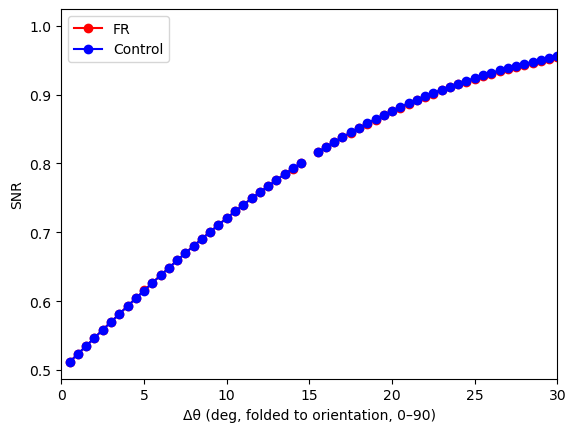

In [52]:
epsilon_idx = 4# index into epsilons list
beta_idx    = 0  # index into betas list
sum_snr_value_fr  = np.vstack([m[:, epsilon_idx, beta_idx] for m in fr_means])   # shape (n_FR, n_bins)
sum_snr_value_ctr = np.vstack([m[:, epsilon_idx, beta_idx] for m in ctr_means])  # shape (n_CTR, n_bins)
mean_fr_snr = np.nanmean(sum_snr_value_fr, axis=0)
mean_ctr_snr = np.nanmean(sum_snr_value_ctr, axis=0)   
#nan points at angles  15,45,75
mean_fr_snr[[29,89,149]] =np.nan
mean_ctr_snr[[29,89,149]] = np.nan
# #convert to performance
performance_fr = stats.norm.cdf(np.sqrt(mean_fr_snr)/2)
performance_ctr = stats.norm.cdf(np.sqrt(mean_ctr_snr)/2)
# performance_fr_sem = (np.exp(-snr_fr/8)/(4*np.sqrt(2*np.pi*snr_fr)))*snr_fr_sem
# performance_ctr_sem = (np.exp(-snr_ctr/8)/(4*np.sqrt(2*np.pi*snr_ctr)))*snr_ctr_sem

# sem_fr= np.nanstd(sum_snr_value_fr, axis=0)/np.sqrt(sum_snr_value_fr.shape[0])
# sem_ctr= np.nanstd(sum_snr_value_ctr, axis=0)/np.sqrt(sum_snr_value_ctr.shape[0])
# plt.plot(conditions_saved, mean_fr_snr, marker='o', label='FR', color  = 'red')
# plt.fill_between(conditions_saved, mean_fr_snr - sem_fr, mean_fr_snr + sem_fr, color='red', alpha=0.3)
# plt.plot(conditions_saved, mean_ctr_snr, marker='o', label='Control', color  = 'blue')
# plt.fill_between(conditions_saved, mean_ctr_snr - sem_ctr, mean_ctr_snr + sem_ctr, color='blue', alpha=0.3)

plt.plot(conditions_saved, performance_fr, marker='o', label='FR', color  = 'red')
plt.plot(conditions_saved, performance_ctr, marker='o', label='Control', color  = 'blue')

# x_behav = np.array([30, 20, 10, 7.5, 5, 2], dtype=float)
# fr_behaviour = np.array([.81, .73, .69, .56, .515, .505], dtype=float)   # example last point ~just above chance
# ctr_behaviour = np.array([.81, .73, .68, .63, .57, .53], dtype=float)

# plt.plot(x_behav, fr_behaviour, marker='o', label='FR', color='red')
# plt.plot(x_behav, ctr_behaviour, marker='o', label='Control', color='blue')

plt.legend()
plt.xlim(0,30)
# plt.ylim(0.5,.8)
plt.xlabel('Δθ (deg, folded to orientation, 0–90)')
plt.ylabel('SNR')

plt.show()